In [22]:
import pandas as pd
import gzip

In [194]:
def Create_taxID_to_SciName(Path="Data/sci_names.dmp.gz"):
    with gzip.open(Path, "rt") as file:
        Name_Lines = [Entry.split("\t") for Entry in file.readlines()]

    taxID_to_SciName = {}
    for Entry in Name_Lines:
        taxID_to_SciName[Entry[0]] = Entry[3]
    
    return taxID_to_SciName

taxID_to_SciName = Create_taxID_to_SciName(Path="Data/sci_names.dmp.gz")

In [195]:
# def taxID_to_SciName(Path="Data/sci_names.dmp.gz"):
#     ### Get files
with gzip.open("Data/GenBank_Bacterial_taxID_lineage.tsv.gz", "rt") as file:
    GB_Lines = [Entry.split("\t") for Entry in file.readlines()]

with gzip.open("Data/IBM_assemblies_taxonomy_metadata.tsv.gz", "rt") as file:
    IBM_Lines = [Entry.split("\t") for Entry in file.readlines()]

In [196]:
Acc_to_Lineage = {}
Acc_to_Rank = {}

### GenBank
for Line in GB_Lines[1:]:

    Accession = Line[0].split(".")[0]

    taxID = Line[1]

    taxID_lineage = Line[2].split(",")
    Rank_lineage = Line[4].split(",")


    Acc_to_Lineage[Accession] = taxID_lineage
    Acc_to_Rank[Accession] = Rank_lineage
      
### IBM
for Line in IBM_Lines[1:]:
    Accession = Line[0]

    taxID = Line[1]

    taxID_lineage = Line[2].split(",")
    Rank_lineage = Line[4].split(",")


    Acc_to_Lineage[Accession] = taxID_lineage
    Acc_to_Rank[Accession] = Rank_lineage

print(len(Acc_to_Lineage))

425473


In [197]:
GB_Lines[2]

['GCA_000007365.1',
 '198804',
 '198804,98794,9,32199,1903409,91347,1236,1224,2,131567',
 'no rank',
 'no rank,no rank,species,genus,family,order,class,phylum,superkingdom,no rank',
 'Buchnera aphidicola str. Sg (Schizaphis graminum)',
 'Buchnera aphidicola str. Sg (Schizaphis graminum),Buchnera aphidicola (Schizaphis graminum),Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,cellular organisms\n']

In [198]:
df = pd.read_table("Data/mash_dist.k21.s1000.txt.gz")

In [199]:
df = df.drop("#query", axis=1)

In [200]:
# df.loc[[0,1,2], :]

In [201]:
Accessions = []
for row in list(df):
    entry = row.split("/")[-1]
    if entry.startswith("GCA"):
        entry = entry.split(".")[0]
    if entry.startswith("GCF"):         
            entry = entry.split(".")[0]
            entry = entry.replace("GCF", "GCA")
    if "-" in entry:
        entry = entry.split("-")[0]
    Accessions.append(entry)
    
print(len(list(df)))    
print(len(Accessions))

9917
9917


In [202]:
Lineages_dict = {}
Rank_dict = {}
for Entry in set(Accessions):
    try:
        Lineages_dict[Entry] = Acc_to_Lineage[Entry]
        Rank_dict[Entry] = Acc_to_Rank[Entry]
    except:
        Lineages_dict[Entry] = "NA"
        Rank_dict[Entry] = "NA"
        print(Entry)

print(len(set(Accessions)))
print(len(Lineages_dict))
print(len(Rank_dict))
Rank_dict['GCA_002192315']

GCA_003060765
GCA_003060725
GCA_003060785
GCA_003060745
9803
9803
9803


['species',
 'genus',
 'family',
 'order',
 'class',
 'phylum',
 'superkingdom',
 'no rank']

In [203]:
Sub_positions = []
Sub_accessions = []
for Acc in Accessions:
    Lineage = Lineages_dict[Acc]
    if  '561' in Lineage or '620' in Lineage or '28901' in Lineage or "573" in Lineage:
        Sub_positions.append(int(Accessions.index(Acc)))
        Sub_accessions.append(Acc)
print(len(Sub_positions))

1238


In [204]:
Sub_species = []
for Acc in Sub_accessions:
    try:
        Lineage = Lineages_dict[Acc]
        Ranks_Lineage = Rank_dict[Acc]
        Index = Ranks_Lineage.index("species")
        Sub_species.append(taxID_to_SciName[Lineage[Index]])
    except:
        print(Lineage, Ranks_Lineage, Index)
        Sub_species.append("NA")

print(len(Sub_species))

1238


In [205]:
Sub_genus = []
for Acc in Sub_accessions:
    try:
        Lineage = Lineages_dict[Acc]
        Ranks_Lineage = Rank_dict[Acc]
        Index = Ranks_Lineage.index("genus")
        Sub_genus.append(taxID_to_SciName[Lineage[Index]])
    except:
        print(Lineage, Ranks_Lineage, Index)
        Sub_genus.append("NA")
print(len(Sub_genus))

1238


In [206]:
Submatrix = df.iloc[Sub_positions, Sub_positions]
# Submatrix.head()

In [207]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
from adjustText import adjust_text
from sklearn import manifold 

In [208]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=2)
results = mds.fit(Submatrix)

In [209]:
### Create plot
coords = results.embedding_
Plot = pd.DataFrame(dict(x=coords[:, 0], y=coords[:, 1], label=Sub_accessions))
Plot["Species"] = Sub_species
Plot["Genus"] = Sub_genus
Plot.head()

,x,y,label,Species,Genus
0,-0.088937,0.046620,GCA_001953695,Salmonella enterica,Salmonella
1,-0.092204,-0.119647,GCA_002192315,Klebsiella pneumoniae,Klebsiella
2,0.081962,-0.036437,GCA_002945135,Escherichia coli,Escherichia
3,-0.083432,0.051129,GCA_000493295,Salmonella enterica,Salmonella
4,0.078968,-0.053048,GCA_000743255,Escherichia coli,Escherichia


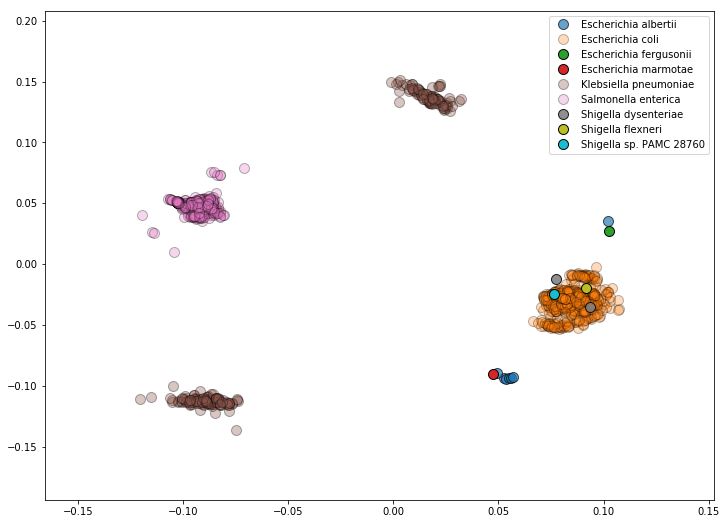

In [210]:
### Plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

### Plot
groups = Plot.groupby('Species')
fig, ax = plt.subplots()
ax.margins(0.2) # Optional, just adds 5% padding to the autoscaling

colors = cm.tab10(np.linspace(0, 1, len(groups)))
alphas = np.linspace(.2, .8, len(groups))
for group, color, alpha in zip(groups, colors, alphas):
    ax.plot(group[1].x, 
            group[1].y, 
            marker='o', 
            linestyle='', 
            ms=10, 
            label=group[0], 
            c=color, 
            markeredgecolor='k', 
            alpha=(float(1)/float(len(group[1])**(.2)))
           )

lgd = pylab.legend()
# ax.legend_.remove()
plt.show()

In [211]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np

In [212]:
X = Plot[['x','y']].values
labels_true = Plot["label"]

In [213]:
db = DBSCAN(eps=0.05, min_samples=30).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

Estimated number of clusters: 4
Homogeneity: 0.163
Completeness: 0.999
V-measure: 0.280


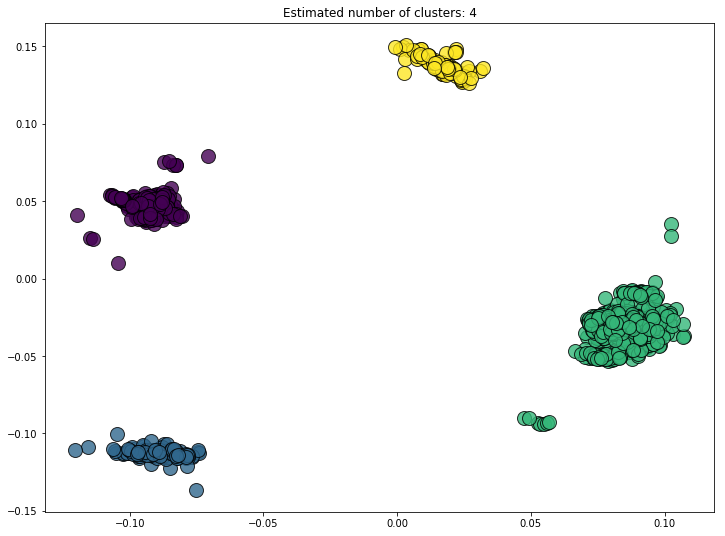

In [214]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))


# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.viridis(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0,0,0, 0]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, alpha=.8)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, alpha=.8)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [215]:
print(len(labels))
print(len(labels_true))

1238
1238


In [216]:
Plot["Cluster"] = labels

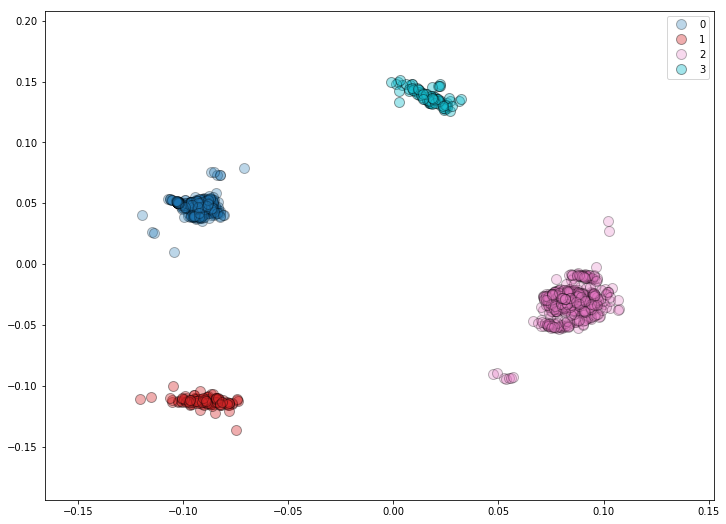

In [217]:
### Plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

### Plot
groups = Plot.groupby('Cluster')
fig, ax = plt.subplots()
ax.margins(0.2) # Optional, just adds 5% padding to the autoscaling

colors = cm.tab10(np.linspace(0, 1, len(groups)))
alphas = np.linspace(.2, .8, len(groups))
for group, color, alpha in zip(groups, colors, alphas):
    ax.plot(group[1].x, 
            group[1].y, 
            marker='o', 
            linestyle='', 
            ms=10, 
            label=group[0], 
            c=color, 
            markeredgecolor='k', 
            alpha=(float(1)/float(len(group[1])**(.2)))
           )

lgd = pylab.legend()
# ax.legend_.remove()
plt.show()

In [218]:
Kleb = Plot.loc[Plot['Species'] == 'Klebsiella pneumoniae']
Kleb.head()

,x,y,label,Species,Genus,Cluster
1,-0.092204,-0.119647,GCA_002192315,Klebsiella pneumoniae,Klebsiella,1
15,-0.084457,-0.110041,GCA_002753075,Klebsiella pneumoniae,Klebsiella,1
18,0.012811,0.141363,GCA_001936035,Klebsiella pneumoniae,Klebsiella,3
24,0.002497,0.133021,GCA_001548315,Klebsiella pneumoniae,Klebsiella,3
27,-0.084465,-0.110036,GCA_002752975,Klebsiella pneumoniae,Klebsiella,1


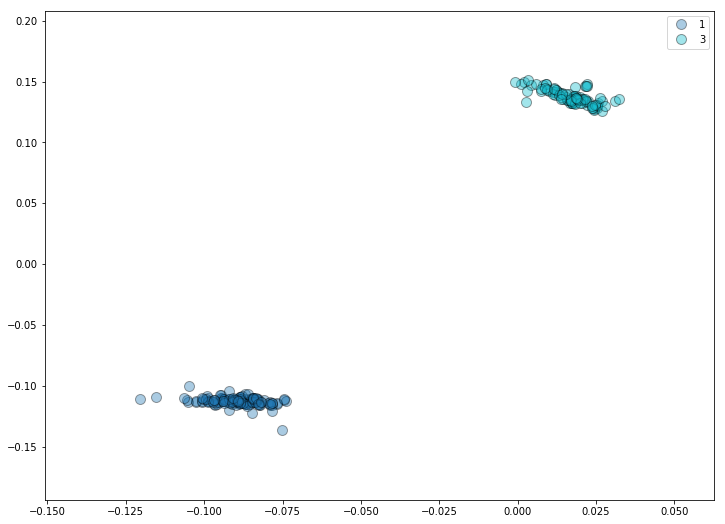

In [219]:
### Plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

### Plot
groups = Kleb.groupby('Cluster')
fig, ax = plt.subplots()
ax.margins(0.2) # Optional, just adds 5% padding to the autoscaling

colors = cm.tab10(np.linspace(0, 1, len(groups)))
alphas = np.linspace(.2, .8, len(groups))
for group, color, alpha in zip(groups, colors, alphas):
    ax.plot(group[1].x, 
            group[1].y, 
            marker='o', 
            linestyle='', 
            ms=10, 
            label=group[0], 
            c=color, 
            markeredgecolor='k', 
            alpha=(float(1)/float(len(group[1])**(.2)))
           )

lgd = pylab.legend()
# ax.legend_.remove()
plt.show()

1238


In [262]:
Sub_positions = []
Sub_accessions = []
for Acc in Accessions:
    Lineage = Lineages_dict[Acc]
    if "570" in Lineage:
        Sub_positions.append(int(Accessions.index(Acc)))
        Sub_accessions.append(Acc)
print(len(Sub_positions))

Kleb_Submatrix = df.iloc[Sub_positions, Sub_positions]
Kleb_Submatrix.head()

284


,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002192315.1_ASM219231v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002753075.1_ASM275307v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001936035.1_ASM193603v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001596075.2_ASM159607v2_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001548315.1_ASM154831v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002752975.1_ASM275297v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001908595.1_ASM190859v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002269295.1_ASM226929v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002197225.1_ASM219722v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001559215.2_ASM155921v2_genomic.fna.gz,...,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001902515.1_ASM190251v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001278905.1_ASM127890v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002947505.1_ASM294750v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001548355.1_ASM154835v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002180155.1_ASM218015v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000364385.3_ASM36438v3_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002753035.1_ASM275303v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001708225.1_ASM170822v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000009885.1_ASM988v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000334515.1_ASM33451v1_genomic.fna.gz
5,0.000000,0.010827,0.010655,0.053733,0.057440,0.010784,0.011264,0.010272,0.011576,0.132399,...,0.010655,0.053940,0.145727,0.140258,0.011576,0.012122,0.012587,0.011397,0.010870,0.124491
57,0.010827,0.000000,0.009938,0.056983,0.056983,0.000048,0.011711,0.004270,0.003966,0.119909,...,0.012307,0.057211,0.135380,0.136948,0.005281,0.004301,0.012030,0.011666,0.011044,0.105264
65,0.010655,0.009938,0.000000,0.054359,0.056983,0.009938,0.012447,0.009447,0.011442,0.133864,...,0.010697,0.053527,0.133864,0.140258,0.010914,0.011264,0.010741,0.010356,0.010483,0.133864
96,0.053733,0.056983,0.054359,0.000000,0.062633,0.056983,0.056532,0.058137,0.059330,0.133864,...,0.054149,0.010612,0.142009,0.138572,0.057671,0.059819,0.055865,0.055646,0.055646,0.132399
125,0.057440,0.056983,0.056983,0.062633,0.000000,0.056983,0.058373,0.055428,0.059330,0.133864,...,0.058373,0.062899,0.145727,0.147707,0.057903,0.058373,0.055212,0.056532,0.057671,0.133864


In [263]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=2)
results = mds.fit(Submatrix)

In [264]:
### Create plot
coords = results.embedding_
Plot_kleb = pd.DataFrame(dict(x=coords[:, 0], y=coords[:, 1], label=Sub_accessions))

Plot_kleb.head()

ValueError: arrays must all be same length

In [ ]:
Kleb.head()

In [189]:
df = pd.merge(Kleb[['label', 'Cluster']], Plot_kleb, on=['label','label'])
df.head()

,label,Cluster,x,y
0,GCA_002192315,1,-0.002620,0.004474
1,GCA_002753075,1,0.003262,-0.000067
2,GCA_001936035,3,-0.000914,0.004611
3,GCA_001548315,3,-0.034151,0.044687
4,GCA_002752975,1,0.003197,-0.000129


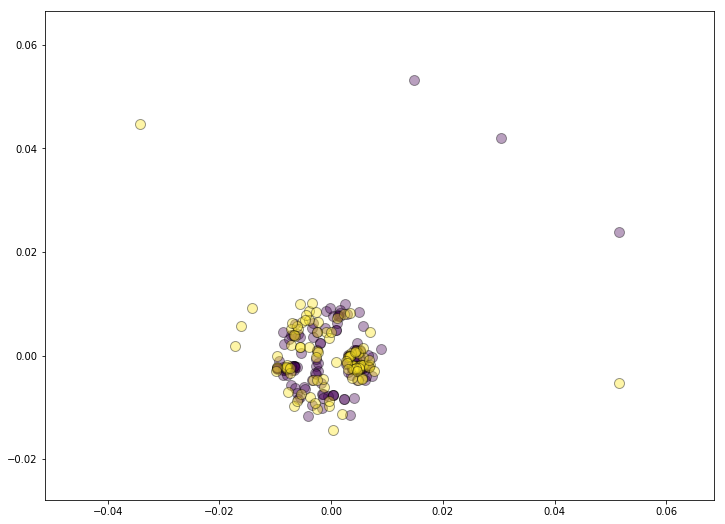

In [191]:
### Plot parameters
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

### Plot
groups = df.groupby('Cluster')
fig, ax = plt.subplots()
ax.margins(0.2) # Optional, just adds 5% padding to the autoscaling

colors = cm.viridis(np.linspace(0, 1, len(groups)))
alphas = np.linspace(.2, .8, len(groups))
for group, color, alpha in zip(groups, colors, alphas):
    ax.plot(group[1].x, 
            group[1].y, 
            marker='o', 
            linestyle='', 
            ms=10, 
            label=group[0], 
            c=color, 
            markeredgecolor='k', 
            alpha=(float(1)/float(len(group[1])**(.2)))
           )

lgd = pylab.legend()
ax.legend_.remove()
plt.show()

In [221]:
from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd
from scipy.spatial.distance import pdist

In [223]:
### Create a hierarchical tree ###
distArray = ssd.squareform(Kleb_Submatrix)
row_clusters = linkage(distArray, metric='euclidean', method='complete')

In [241]:
Kleb_Submatrix.head()

,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002192315.1_ASM219231v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002753075.1_ASM275307v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001936035.1_ASM193603v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001548315.1_ASM154831v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002752975.1_ASM275297v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001908595.1_ASM190859v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002269295.1_ASM226929v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002197225.1_ASM219722v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000764615.1_ASM76461v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_003031325.1_ASM303132v1_genomic.fna.gz,...,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002202275.1_ASM220227v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002852995.2_ASM285299v2_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000717515.1_ASM71751v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001908515.1_ASM190851v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001902515.1_ASM190251v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002180155.1_ASM218015v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000364385.3_ASM36438v3_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_002753035.1_ASM275303v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_001708225.1_ASM170822v1_genomic.fna.gz,/Users/charlotte.darby@ibm.com/ncbi-genomes-2018-06-13/GCF_000009885.1_ASM988v1_genomic.fna.gz
5,0.000000,0.010827,0.010655,0.057440,0.010784,0.011264,0.010272,0.011576,0.011756,0.011220,...,0.012682,0.011666,0.010104,0.010441,0.010655,0.011576,0.012122,0.012587,0.011397,0.010870
57,0.010827,0.000000,0.009938,0.056983,0.000048,0.011711,0.004270,0.003966,0.011984,0.013502,...,0.010784,0.010784,0.005216,0.011576,0.012307,0.005281,0.004301,0.012030,0.011666,0.011044
65,0.010655,0.009938,0.000000,0.056983,0.009938,0.012447,0.009447,0.011442,0.011576,0.011353,...,0.009855,0.009528,0.009855,0.010230,0.010697,0.010914,0.011264,0.010741,0.010356,0.010483
125,0.057440,0.056983,0.056983,0.000000,0.056983,0.058373,0.055428,0.059330,0.059089,0.058848,...,0.057440,0.057671,0.056308,0.056983,0.058373,0.057903,0.058373,0.055212,0.056532,0.057671
149,0.010784,0.000048,0.009938,0.056983,0.000000,0.011621,0.004301,0.003936,0.011984,0.013453,...,0.010697,0.010741,0.005152,0.011531,0.012214,0.005249,0.004270,0.011984,0.011621,0.011001


In [255]:
Sub_species = []
for Acc in Sub_accessions:
    try:
        Lineage = Lineages_dict[Acc]
        Ranks_Lineage = Rank_dict[Acc]
        Index = Ranks_Lineage.index("species")
        Sub_species.append(taxID_to_SciName[Lineage[Index]])
    except:
        print(Lineage, Ranks_Lineage, Index)
        Sub_species.append("NA")

print(len(Sub_species))

['2026240', '570', '543', '91347', '1236', '1224', '2', '131567'] ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom', 'no rank'] 0
284


In [256]:
Clustering = pd.DataFrame(row_clusters,
             columns=['row label 1',
                      'row label 2',
                      'distance', 
                      'no. items in cluster'
                     ],
             index=['cluster {}'.format(i+1) for i in range(row_clusters.shape[0])]
            )

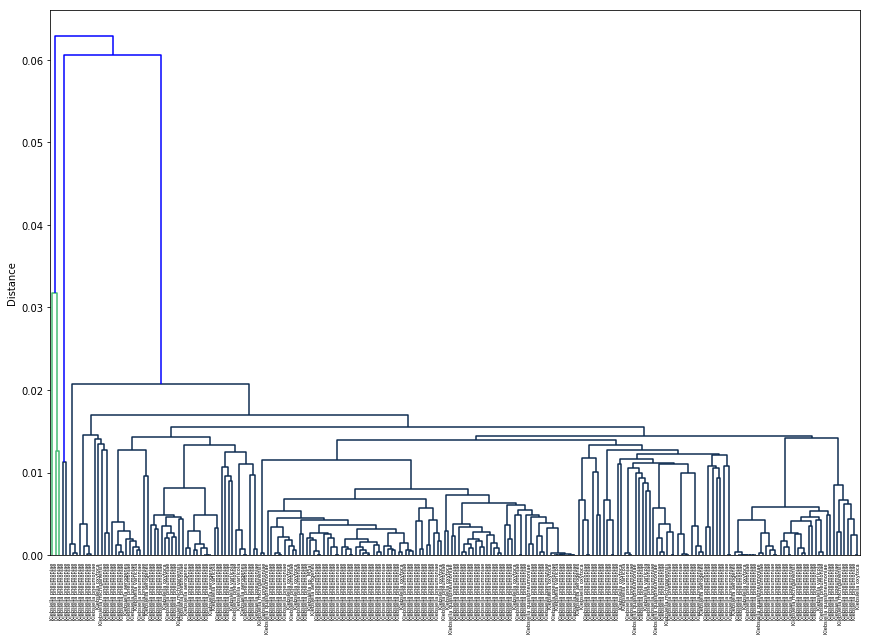

In [257]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

row_dendr = dendrogram(row_clusters, labels=Sub_species)

plt.tight_layout()
plt.ylabel('Distance')
plt.grid(False)
plt.show()
# plt.close()

In [258]:
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from scipy.cluster.hierarchy import linkage
import numpy as np
from matplotlib import pyplot
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy

In [259]:
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

Method:	 ward


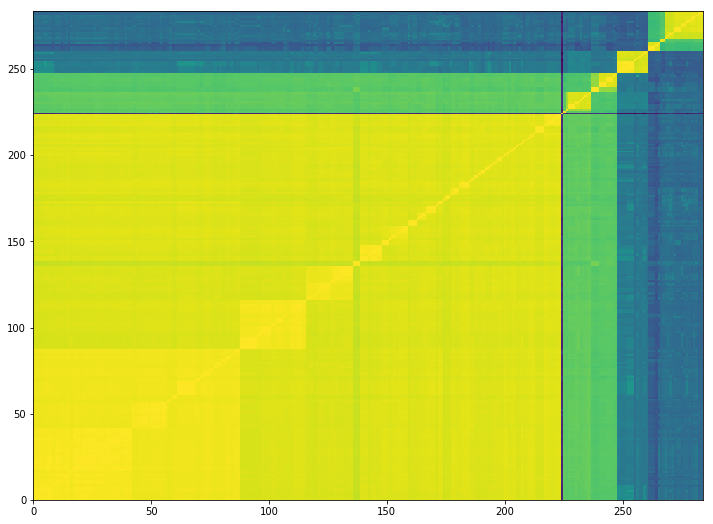

Method:	 single


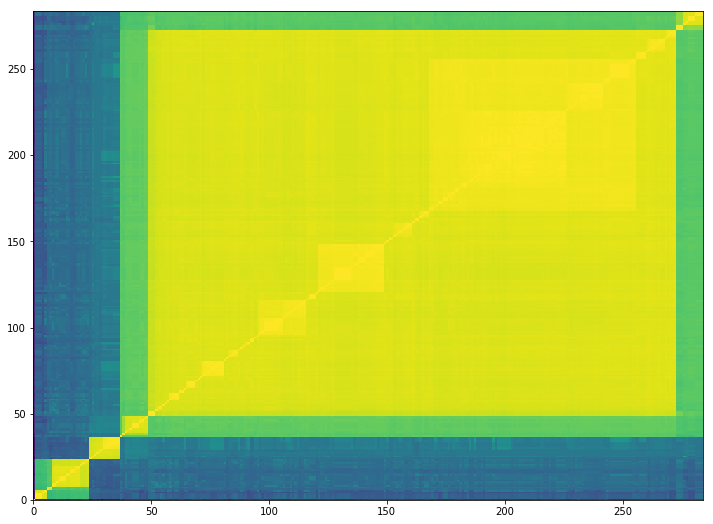

Method:	 average


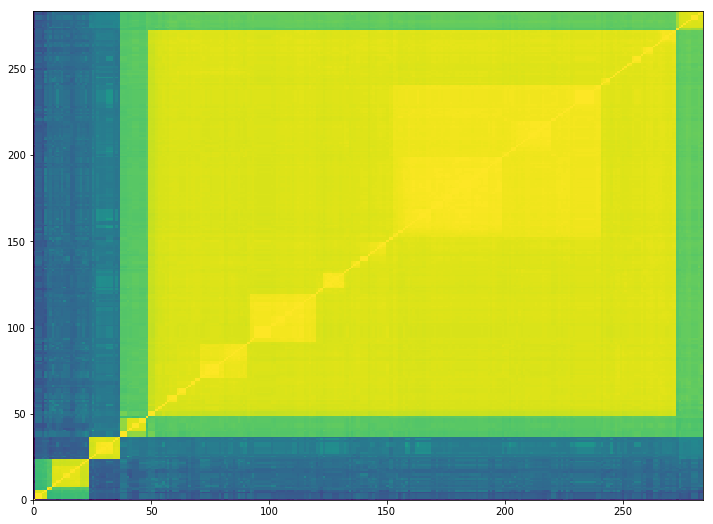

Method:	 complete


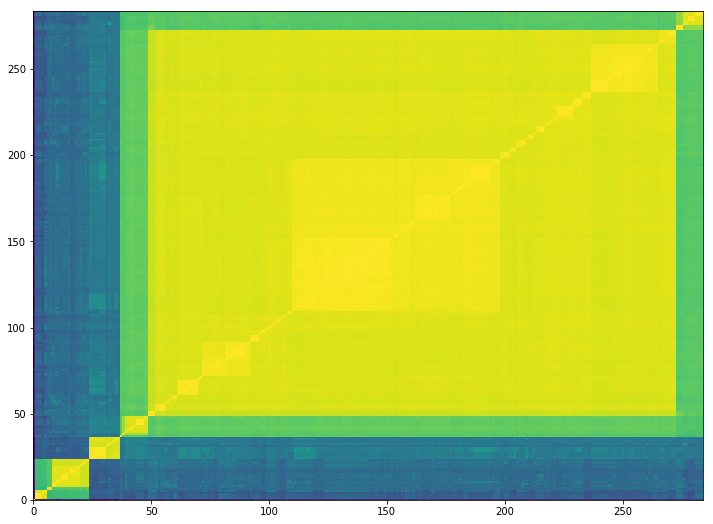

In [260]:
methods = ["ward","single","average","complete"]
for method in methods:
    print("Method:\t",method)
    
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(Kleb_Submatrix.values,method)
    
    plt.pcolormesh(ordered_dist_mat, cmap='viridis_r')
    plt.xlim([0,len(ordered_dist_mat)])
    plt.ylim([0,len(ordered_dist_mat)])
    plt.show()
#     plt.close()

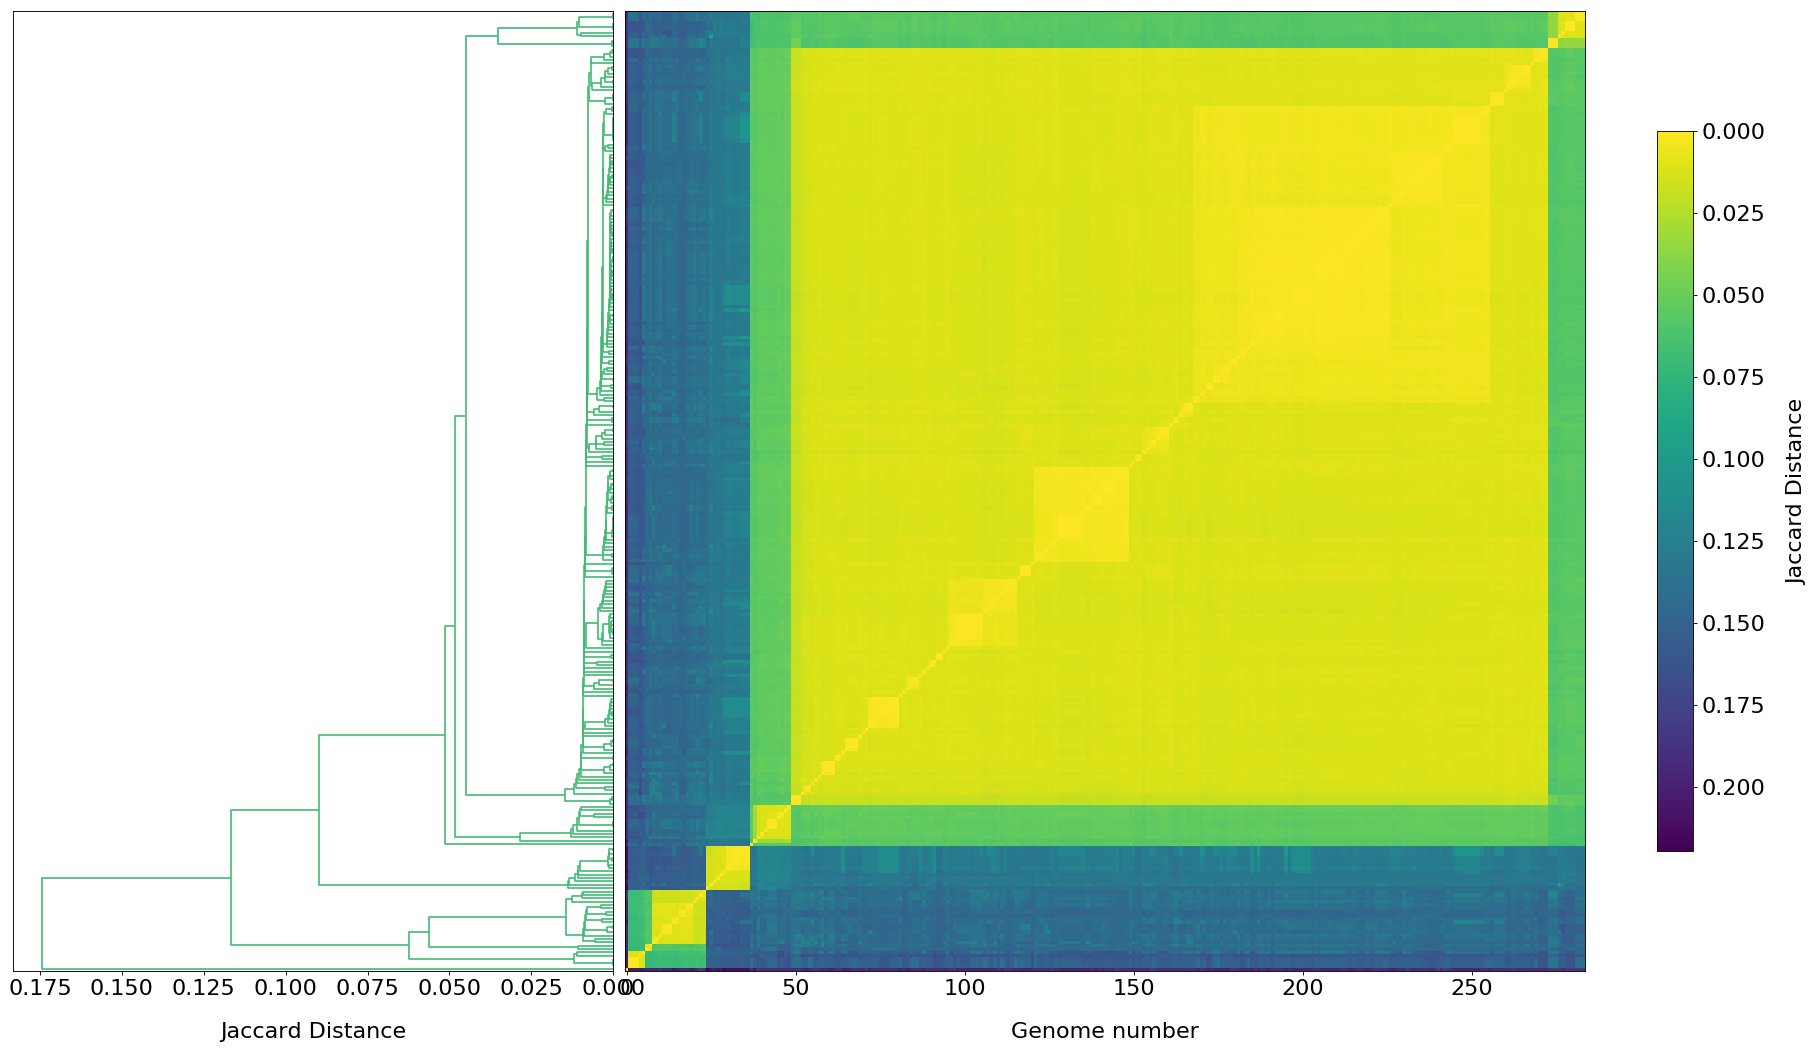

In [261]:
### Combine Tree and Heatmap using ward linkage ###

ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(Kleb_Submatrix.values,'single')
ordered_dist_mat = ordered_dist_mat[::-1]

### Make Plot ###
fig=plt.figure(facecolor='white')
fig.set_size_inches(30, 20)
fig.set_dpi(80)
### Plot Dendrogram ###
axd = fig.add_axes([0.05, 0.1, 0.25, 0.6])

hierarchy.set_link_color_palette(['#42bb72ff', "#0c2a50ff", "#0c2a50ff", "#0c2a50ff"])

row_dendr = dendrogram(res_linkage, 
                       labels=Sub_accessions, 
                       orientation='left', 
                       color_threshold=0.5, 
                       above_threshold_color='#440154ff')

axd.set_xlabel('Jaccard Distance', fontsize=20, labelpad=20)
axd.tick_params(axis='both', which='major', labelsize=20)
axd.axes.get_yaxis().set_visible(False)


### Plot Heatmap ###
axm = fig.add_axes([0.15, 0.1, 0.6, 0.6])

cax = axm.matshow(ordered_dist_mat, interpolation='nearest', cmap='viridis_r')
axm.grid(False)
axm.tick_params(axis='both', which='major', labelsize=20)
axm.axes.get_yaxis().set_visible(False)
axm.xaxis.tick_bottom()
axm.set_xlabel('Genome number', fontsize=20, labelpad=20)

### Color legend ###
colorbar = fig.colorbar(cax,fraction=0.025)
colorbar.ax.invert_yaxis()
colorbar.set_label(label='Jaccard Distance',size=20, labelpad=20)
colorbar.ax.tick_params(labelsize=20) 

### Figure size and resolution ###

# fig.savefig('149539_CCSC_outgroup_subtracted_Hierarchical_tree_and_heatmap_ward-dist.pdf')